# Joe Stanley
### ECE522 - EXAM1

In [1]:
# Import Necessary Libraries
import numpy as np
_np = np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import electricpy as ep
from electricpy import compose
from electricpy.constants import *

# Set Boolean Control for Report Style
debug = True

## Problem I:
### Part A:
Given the parameters described below, find: $\text{slip}_{\text{rated}}$, $\omega_{r-\text{rated}}$, and $\Lambda_{dr_\text{rated}}$. Rated is defined to mean that the operating conditions are such that: $\left|V_{dqs}\right|=1.0\text{pu}$, $T_{em}=1.0\text{pu}$, and $\omega_{es}=1.0\text{pu}$

For this, we know:

$\\
V_{dqs}=r_sI_{dqs}+j\omega_{es}\left(L_sI_{dqs}+\frac{3}{2}L_{sr}I_{dqr}\right)\\
0=r_rI_{dqr}+j(\omega_{es}-\omega_r)\Lambda_{dqr}\\
\Lambda_{dqr}=\frac{3}{2}L_{sr}I_{dqs}+L_{r}I_{dqr}\\
T_{em}=\frac{3p}{4}\frac{\frac{3}{2}L_{sr}}{L_r}\operatorname{Im}\left(\overline{\Lambda_{dqr}}I_{dqs}\right)\\
$

Additionally, we will need to use a few additional equations to solve this system.

$\\
L_s=L_{LS}+L_m\\
L_r=L_{Lr}+L_m\\
L_{sr} = \frac{2}{3}\cdot(L_r - L_{Lr})\cdot a_t
$

As a final note, we will make the following assumptions:

$p=4\qquad a_t=2$

Using an iterative solver (shown in code below), we can now find the terms as:

{{P1_latex}}

S-rated: 0.03723079497495241 	ω-rated: 0.9627692050250476 	Lambda-rated: 0.8976550377456242


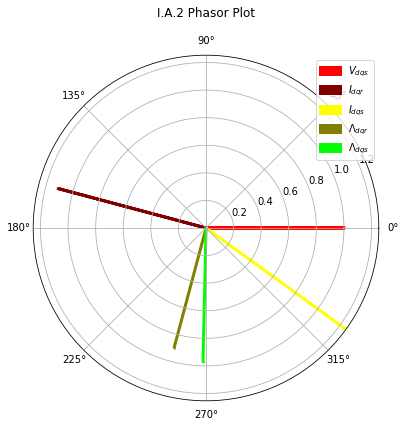

Vdqs: 1.0 ∠ 0.0°
Idqr: 1.114 ∠ 165.077°
Idqs: 1.253 ∠ -35.915°
λdqr: 0.898 ∠ -104.923°
λdqs: 0.97 ∠ -91.303°



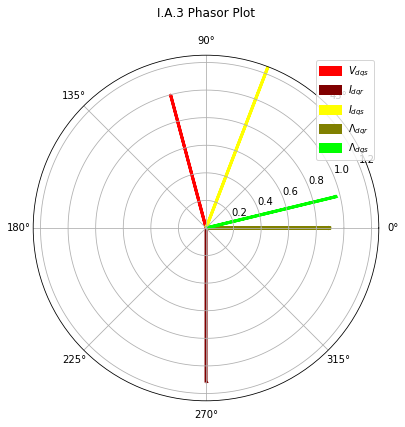

Vdqs: 1.0 ∠ 104.923°
Idqr: 1.114 ∠ -90.0°
Idqs: 1.253 ∠ 69.008°
λdqr: 0.898 ∠ -0.0°
λdqs: 0.97 ∠ 13.62°



In [7]:
# Define Provided Machine Parameters
rs = 0.03 #pu
LLs = 0.1 #pu
Lm = 2.0 #pu
LLr = 0.1 #pu
rr = 0.03 #pu

# Define Rated Criteria
VdqsMag = 1
Tem = 1
wes = 1

# Calculate Additional Inductance Terms
Ls = LLs + Lm
Lr = LLr + Lm

######################################################################
# A.1)

Vds = VdqsMag
Vqs = 0
Idqr,Idqs,LAMdqr,LAMdqs,s_rated,w_rated,lamdr_rated = ep.indmachfocratings(rr,rs,Lm,Llr=LLr,Lls=LLs)
clist = np.array([VdqsMag,Idqr,Idqs,LAMdqr,LAMdqs])

# Generate into Latex Vector
vect_desc = (r"$$\begin{bmatrix}V_{\text{dqs}}\\I_{\text{dqr}}\\"+
            r"I_{\text{dqs}}\\\Lambda_{\text{dqr}}\\ \Lambda_{\text{dqr}}"+
            "\end{bmatrix}=")
P1_latex = vect_desc + ep.clatex(clist,predollar=False,double=True)

print("S-rated:",s_rated,"\tω-rated:",w_rated,"\tLambda-rated:",lamdr_rated)
# Write Results to Data File
with open("constants.txt",'w') as file:
    file.write(str(s_rated)+'\n')
    file.write(str(w_rated)+'\n')
    file.write(str(lamdr_rated)+'\n')

######################################################################
# A.2)
# Use Complex Values to Plot Phasor Diagram
texlabels = [
    "$V_{dqs}$",
    "$I_{dqr}$",
    "$I_{dqs}$",
    "$\\Lambda_{dqr}$",
    "$\\Lambda_{dqs}$",
]
labels = [
    "Vdqs:",
    "Idqr:",
    "Idqs:",
    "λdqr:",
    "λdqs:",
]
ep.phasorplot(clist,"I.A.2 Phasor Plot",texlabels,filename="I-A-2",size=6,linewidth=3,plot=debug)
ep.cprint(clist,label=labels,pretty=True)

######################################################################
# A.3)
# Calculate Phase Shift
shift = np.angle(LAMdqr,deg=True)
# Shift Phasors by Phase Shift Specified
clist *= ep.phs(-shift)
# Use Complex Values to Plot Phasor Diagram
ep.phasorplot(clist,"I.A.3 Phasor Plot",texlabels,filename="I-A-3",size=6,linewidth=3,plot=debug)
ep.cprint(clist,label=labels,pretty=True)

### Part B:

w-slip: 0.0 	w-es 0.0


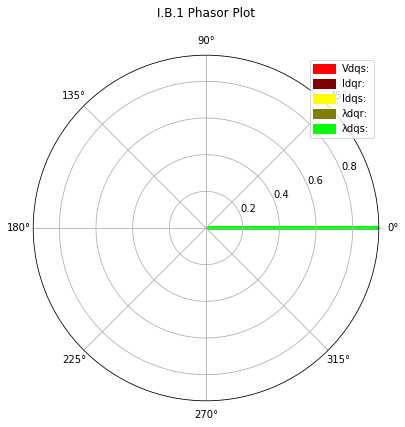

Vdqs: 0.013 ∠ 0.0°
Idqr: 0.0 ∠ 0.0°
Idqs: 0.449 ∠ 0.0°
λdqr: 0.898 ∠ 0.0°
λdqs: 0.943 ∠ 0.0°

w-slip: 0.0 	w-es 0.9627692050250476


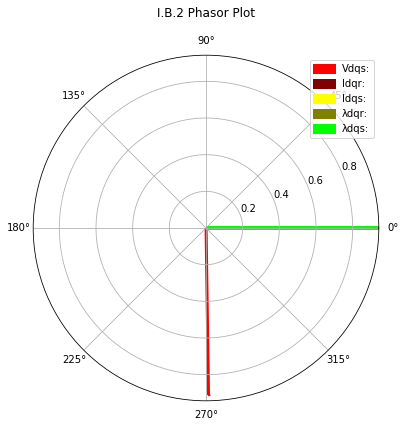

Vdqs: 0.908 ∠ -89.15°
Idqr: 0.0 ∠ 0.0°
Idqs: 0.449 ∠ 0.0°
λdqr: 0.898 ∠ 0.0°
λdqs: 0.943 ∠ 0.0°

w-slip: 0.0 	w-es 1.9255384100500952


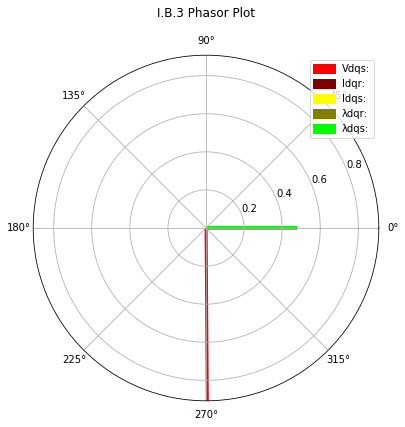

Vdqs: 0.907 ∠ -89.575°
Idqr: 0.0 ∠ 0.0°
Idqs: 0.224 ∠ 0.0°
λdqr: 0.449 ∠ 0.0°
λdqs: 0.471 ∠ 0.0°



In [3]:
# Re-Define Known Values
Tem = 0

######################################################################
# B.1)
wr = 0.0
LAMdr = lamdr_rated

# Generate Phasor Plot
Vdqs,Idqr,Idqs,LAMdqr,LAMdqs,wslip,wes = ep.imfoc_control(Tem,LAMdr,wr,rr,rs,Lm,LLr,LLs)
clist = [Vdqs,Idqr,Idqs,LAMdqr,LAMdqs]
print("w-slip:",wslip,"\tw-es",wes)
ep.phasorplot(clist,"I.B.1 Phasor Plot",labels,filename="I-B-1",size=6,linewidth=3,plot=debug)
ep.cprint(clist,label=labels,pretty=True)

######################################################################
# B.2)
wr = w_rated
LAMdr = lamdr_rated

# Generate Phasor Plot
Vdqs,Idqr,Idqs,LAMdqr,LAMdqs,wslip,wes = ep.imfoc_control(Tem,LAMdr,wr,rr,rs,Lm,LLr,LLs)
clist = [Vdqs,Idqr,Idqs,LAMdqr,LAMdqs]
print("w-slip:",wslip,"\tw-es",wes)
ep.phasorplot(clist,"I.B.2 Phasor Plot",labels,filename="I-B-2",size=6,linewidth=3,plot=debug)
ep.cprint(clist,label=labels,pretty=True)

######################################################################
# B.3)
wr = 2*w_rated
LAMdr = lamdr_rated/2

# Generate Phasor Plot
Vdqs,Idqr,Idqs,LAMdqr,LAMdqs,wslip,wes = ep.imfoc_control(Tem,LAMdr,wr,rr,rs,Lm,LLr,LLs)
clist = [Vdqs,Idqr,Idqs,LAMdqr,LAMdqs]
print("w-slip:",wslip,"\tw-es",wes)
ep.phasorplot(clist,"I.B.3 Phasor Plot",labels,filename="I-B-3",size=6,linewidth=3,plot=debug)
ep.cprint(clist,label=labels,pretty=True)

### Part C:

w-slip: 0.03723079497477497 	w-es 0.03723079497477497


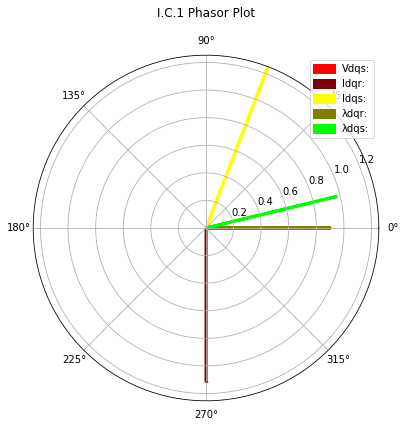

Vdqs: 0.005 ∠ 0.0°
Idqr: 1.114 ∠ -90.0°
Idqs: 1.253 ∠ 69.008°
λdqr: 0.898 ∠ 0.0°
λdqs: 0.97 ∠ 13.62°

w-slip: 0.03723079497477497 	w-es 0.9999999999998226


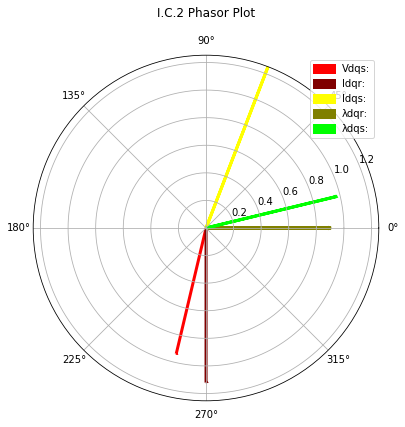

Vdqs: 0.933 ∠ -103.324°
Idqr: 1.114 ∠ -90.0°
Idqs: 1.253 ∠ 69.008°
λdqr: 0.898 ∠ 0.0°
λdqs: 0.97 ∠ 13.62°

w-slip: 0.07446158994954993 	w-es 1.9999999999996452


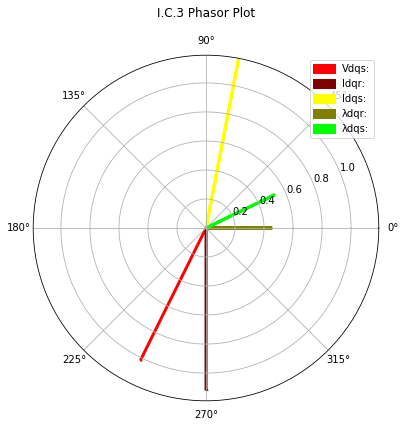

Vdqs: 1.013 ∠ -116.377°
Idqr: 1.114 ∠ -90.0°
Idqs: 1.191 ∠ 79.14°
λdqr: 0.449 ∠ 0.0°
λdqs: 0.524 ∠ 25.854°



In [4]:
# C.1)
Tem = 1.0
wr = 0.0
LAMdr = lamdr_rated

# Generate Phasor Plot
Vdqs,Idqr,Idqs,LAMdqr,LAMdqs,wslip,wes = ep.imfoc_control(Tem,LAMdr,wr,rr,rs,Lm,LLr,LLs)
clist = [Vdqs,Idqr,Idqs,LAMdqr,LAMdqs]
print("w-slip:",wslip,"\tw-es",wes)
ep.phasorplot(clist,"I.C.1 Phasor Plot",labels,filename="I-C-1",size=6,linewidth=3,plot=debug)
ep.cprint(clist,label=labels,pretty=True)

######################################################################
# C.2)
Tem = 1.0
wr = w_rated
LAMdr = lamdr_rated

# Generate Phasor Plot
Vdqs,Idqr,Idqs,LAMdqr,LAMdqs,wslip,wes = ep.imfoc_control(Tem,LAMdr,wr,rr,rs,Lm,LLr,LLs)
clist = [Vdqs,Idqr,Idqs,LAMdqr,LAMdqs]
print("w-slip:",wslip,"\tw-es",wes)
ep.phasorplot(clist,"I.C.2 Phasor Plot",labels,filename="I-C-2",size=6,linewidth=3,plot=debug)
ep.cprint(clist,label=labels,pretty=True)

######################################################################
# C.3)
Tem = 0.5
wr = 2*w_rated
LAMdr = lamdr_rated/2

# Generate Phasor Plot
Vdqs,Idqr,Idqs,LAMdqr,LAMdqs,wslip,wes = ep.imfoc_control(Tem,LAMdr,wr,rr,rs,Lm,LLr,LLs)
clist = [Vdqs,Idqr,Idqs,LAMdqr,LAMdqs]
print("w-slip:",wslip,"\tw-es",wes)
ep.phasorplot(clist,"I.C.3 Phasor Plot",labels,filename="I-C-3",size=6,linewidth=3,plot=debug)
ep.cprint(clist,label=labels,pretty=True)